In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
print("="*80)
print("BANKING STRESS TESTING - FEATURE ENGINEERING")
print("="*80)
print("\n All libraries imported successfully!")
print(f"   Pandas: {pd.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Scikit-learn: {sklearn.__version__}")

BANKING STRESS TESTING - FEATURE ENGINEERING

 All libraries imported successfully!
   Pandas: 2.1.4
   NumPy: 1.24.3
   Scikit-learn: 1.6.1


In [4]:
import pandas as pd
df = pd.read_parquet("../data_work/loans_cleaned.parquet")
print(" Data loaded successfully!")

 Data loaded successfully!


In [5]:
print(df.head())

         id    issue_d issue_q_start  loan_amnt  term_m  int_rate  \
0  40932667 2015-02-01    2015-01-01      28000      60    0.0999   
1  41120433 2015-02-01    2015-01-01      10300      60    0.1399   
2  40959606 2015-02-01    2015-01-01      35000      60    0.1786   
3  41143031 2015-02-01    2015-01-01      15000      36    0.0692   
4  40932682 2015-02-01    2015-01-01      35000      60    0.1699   

   installment  annual_inc  log_annual_inc        dti  ...  emp_length  \
0   594.780029    103000.0       11.542494   9.980000  ...        10.0   
1   239.610001     42000.0       10.645449  31.559999  ...         6.0   
2   886.109985    100000.0       11.512935  18.120001  ...        10.0   
3   462.609985    125000.0       11.736077  32.150002  ...         4.0   
4   869.659973    100000.0       11.512935  20.340000  ...         3.0   

   home_ownership             purpose      GDPC1 gdp_scaled    UNRATE  \
0            rent  debt_consolidation  18666.621  18.666621  5.5333

In [6]:
#Data Exploration
print("\n" + "="*80)
print("DATA EXPLORATION")
print("="*80)

print("\n📋 Dataset Columns:")
print("-"*80)
for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    n_unique = df[col].nunique()
    print(f"{i:3d}. {col:30s} | {dtype:15s} | Missing: {missing_pct:5.1f}% | Unique: {n_unique}")


DATA EXPLORATION

📋 Dataset Columns:
--------------------------------------------------------------------------------
  1. id                             | object          | Missing:   0.0% | Unique: 2258953
  2. issue_d                        | datetime64[ns]  | Missing:   0.0% | Unique: 139
  3. issue_q_start                  | datetime64[ns]  | Missing:   0.0% | Unique: 47
  4. loan_amnt                      | int32           | Missing:   0.0% | Unique: 1572
  5. term_m                         | int16           | Missing:   0.0% | Unique: 2
  6. int_rate                       | float64         | Missing:   0.0% | Unique: 673
  7. installment                    | float64         | Missing:   0.0% | Unique: 93266
  8. annual_inc                     | float64         | Missing:   0.0% | Unique: 89090
  9. log_annual_inc                 | float64         | Missing:   0.0% | Unique: 89090
 10. dti                            | float64         | Missing:   0.0% | Unique: 10155
 11. debt_t

In [7]:
# Separate column types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n Column Types:")
print(f"   Numeric: {len(numeric_cols)}")
print(f"   Categorical: {len(categorical_cols)}")

# Statistical summary
print("\n Statistical Summary:")
display(df.describe())


 Column Types:
   Numeric: 16
   Categorical: 6

 Statistical Summary:


,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,annual_inc,log_annual_inc,dti,debt_to_income_ratio,fico,GDPC1,gdp_scaled,UNRATE,CPIAUCSL,cpi_scaled,FEDFUNDS,target
count,2258953,2258953,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06
mean,2016-05-02 07:02:41.891814144,2016-04-02 10:53:00.710001408,1.504388e+04,4.290806e+01,1.309198e-01,4.457259e+02,7.755192e+04,1.109768e+01,1.872460e+01,1.872460e-01,6.985788e+02,1.915688e+04,1.915688e+01,5.046595e+00,2.415637e+02,2.415637e+00,7.295409e-01,1.192097e-01
min,2007-06-01 00:00:00,2007-04-01 00:00:00,5.000000e+02,3.600000e+01,5.310000e-02,4.930000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.100000e+02,1.626915e+04,1.626915e+01,3.766667e+00,2.066310e+02,2.066310e+00,7.333333e-02,0.000000e+00
25%,2015-04-01 00:00:00,2015-04-01 00:00:00,8.000000e+03,3.600000e+01,9.490000e-02,2.516100e+02,4.600000e+04,1.073642e+01,1.189000e+01,1.189000e-01,6.750000e+02,1.878224e+04,1.878224e+01,4.166667e+00,2.369600e+02,2.369600e+00,1.366667e-01,0.000000e+00
50%,2016-07-01 00:00:00,2016-07-01 00:00:00,1.290000e+04,3.600000e+01,1.262000e-01,3.778900e+02,6.500000e+04,1.108216e+01,1.784000e+01,1.784000e-01,6.900000e+02,1.919794e+04,1.919794e+01,4.900000e+00,2.406073e+02,2.406073e+00,3.966667e-01,0.000000e+00
75%,2017-11-01 00:00:00,2017-10-01 00:00:00,2.000000e+04,6.000000e+01,1.599000e-01,5.930600e+02,9.300000e+04,1.144037e+01,2.449000e+01,2.449000e-01,7.150000e+02,1.988235e+04,1.988235e+01,5.433333e+00,2.472383e+02,2.472383e+00,1.203333e+00,0.000000e+00
max,2018-12-01 00:00:00,2018-10-01 00:00:00,4.000000e+04,6.000000e+01,3.099000e-01,1.719830e+03,1.000000e+06,1.381551e+01,2.000000e+02,2.000000e+00,8.450000e+02,2.030487e+04,2.030487e+01,9.933333e+00,2.527110e+02,2.527110e+00,5.250000e+00,1.000000e+00
std,NaN,NaN,9.188072e+03,1.086611e+01,4.831389e-02,2.671100e+02,5.432038e+04,5.559126e-01,1.044305e+01,1.044305e-01,3.300445e+01,8.177724e+02,8.177724e-01,1.168990e+00,6.832682e+00,6.832682e-02,6.996577e-01,3.240351e-01


In [8]:
#Data Quality Check
print("\n" + "="*80)
print("DATA QUALITY ANALYSIS")
print("="*80)

print(f"\n Data Quality Metrics:")
print(f"   Total cells: {df.shape[0] * df.shape[1]:,}")
print(f"   Missing values: {df.isnull().sum().sum():,}")
print(f"   Duplicate rows: {df.duplicated().sum():,}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for constant columns
constant_cols = [col for col in numeric_cols if df[col].nunique() <= 1]
if constant_cols:
    print(f"\n  Constant columns found: {constant_cols}")
else:
    print("\n No constant columns")

# Missing value visualization
if df.isnull().sum().sum() > 0:
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    missing_data.plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.xlabel('Column')
    plt.ylabel('Missing Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



DATA QUALITY ANALYSIS

 Data Quality Metrics:
   Total cells: 54,214,872
   Missing values: 0
   Duplicate rows: 0
   Memory usage: 1084.69 MB

 No constant columns


In [9]:
#Handle Missing Values
print("\n" + "="*80)
print("HANDLING MISSING VALUES")
print("="*80)

missing_before = df.isnull().sum().sum()
print(f"\nMissing values before: {missing_before}")

# Handle numeric columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"   ✓ Filled {col} with median: {median_val:.2f}")

# Handle categorical columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        df[col].fillna(mode_val, inplace=True)
        print(f"   ✓ Filled {col} with mode: {mode_val}")

missing_after = df.isnull().sum().sum()
print(f"\n Missing values after: {missing_after}")
print(f"   Handled: {missing_before - missing_after} missing values")


HANDLING MISSING VALUES

Missing values before: 0

 Missing values after: 0
   Handled: 0 missing values


In [10]:
# Encode Categorical Variables

print("\n" + "="*80)
print("ENCODING CATEGORICAL VARIABLES")
print("="*80)

if len(categorical_cols) > 0:
    print(f"\n  Encoding {len(categorical_cols)} categorical columns...")
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"   ✓ {col}: {df[col].nunique()} unique values → encoded")
    
    # Update numeric columns list
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\n Total numeric columns now: {len(numeric_cols)}")
else:
    print("\n No categorical columns to encode")


ENCODING CATEGORICAL VARIABLES

  Encoding 6 categorical columns...
   ✓ id: 2258953 unique values → encoded
   ✓ grade: 7 unique values → encoded
   ✓ sub_grade: 35 unique values → encoded
   ✓ emp_length: 12 unique values → encoded
   ✓ home_ownership: 6 unique values → encoded
   ✓ purpose: 14 unique values → encoded

 Total numeric columns now: 22


In [11]:
#Feauture Engineering - Statistical features
print("\n" + "="*80)
print("FEATURE ENGINEERING - STATISTICAL FEATURES")
print("="*80)

original_count = len(df.columns)
stat_features = 0

print("\n Creating statistical transformations...")

for col in numeric_cols[:15]:  # Limit to first 15 columns
    # Z-score
    mean_val = df[col].mean()
    std_val = df[col].std()
    if std_val > 0:
        df[f'{col}_zscore'] = (df[col] - mean_val) / std_val
        stat_features += 1
    
    # Log transformation (if all positive)
    if (df[col] > 0).all():
        df[f'{col}_log'] = np.log1p(df[col])
        stat_features += 1
    
    # Square root (if all non-negative)
    if (df[col] >= 0).all():
        df[f'{col}_sqrt'] = np.sqrt(df[col])
        stat_features += 1

print(f" Created {stat_features} statistical features")


FEATURE ENGINEERING - STATISTICAL FEATURES

 Creating statistical transformations...
 Created 41 statistical features


In [12]:
#Feature Engineering - Polynomial features
print("\n" + "="*80)
print("FEATURE ENGINEERING - POLYNOMIAL FEATURES")
print("="*80)

poly_features = 0

print("\n Creating polynomial features...")

for col in numeric_cols[:12]:
    df[f'{col}_squared'] = df[col] ** 2
    df[f'{col}_cubed'] = df[col] ** 3
    poly_features += 2

print(f" Created {poly_features} polynomial features")


FEATURE ENGINEERING - POLYNOMIAL FEATURES

 Creating polynomial features...
 Created 24 polynomial features


In [13]:
#Feature Engineering - Interaction features
print("\n" + "="*80)
print("FEATURE ENGINEERING - INTERACTION FEATURES")
print("="*80)

interaction_features = 0

print("\n Creating interaction features...")

top_features = numeric_cols[:8]
for i in range(len(top_features)):
    for j in range(i + 1, min(i + 3, len(top_features))):
        col1, col2 = top_features[i], top_features[j]
        
        # Multiplication
        df[f'{col1}_x_{col2}'] = df[col1] * df[col2]
        interaction_features += 1
        
        # Addition
        df[f'{col1}_plus_{col2}'] = df[col1] + df[col2]
        interaction_features += 1

print(f" Created {interaction_features} interaction features")


FEATURE ENGINEERING - INTERACTION FEATURES

 Creating interaction features...
 Created 26 interaction features


In [14]:
#Feature Engineering - ratio features
print("\n" + "="*80)
print("FEATURE ENGINEERING - RATIO FEATURES")
print("="*80)

ratio_features = 0

print("\n Creating ratio features...")

for i in range(len(top_features)):
    for j in range(i + 1, min(i + 2, len(top_features))):
        col1, col2 = top_features[i], top_features[j]
        
        if (df[col2] != 0).all() and df[col2].std() > 0:
            df[f'{col1}_div_{col2}'] = df[col1] / (df[col2] + 1e-8)
            ratio_features += 1

print(f" Created {ratio_features} ratio features")


FEATURE ENGINEERING - RATIO FEATURES

 Creating ratio features...
 Created 3 ratio features


In [15]:
#Feature Engineering - Threshold feature
print("\n" + "="*80)
print("FEATURE ENGINEERING - THRESHOLD FEATURES")
print("="*80)

threshold_features = 0

print("\n  Creating threshold/binary features...")

for col in numeric_cols[:12]:
    # Above median
    median_val = df[col].median()
    df[f'{col}_above_median'] = (df[col] > median_val).astype(int)
    threshold_features += 1
    
    # Quartile bins
    try:
        df[f'{col}_quartile'] = pd.qcut(df[col], q=4, labels=[0, 1, 2, 3], duplicates='drop')
        threshold_features += 1
    except:
        pass

print(f" Created {threshold_features} threshold features")


FEATURE ENGINEERING - THRESHOLD FEATURES

  Creating threshold/binary features...
 Created 23 threshold features


In [16]:
#Feature Engineering - Aggregate features
print("\n" + "="*80)
print("FEATURE ENGINEERING - AGGREGATE FEATURES")
print("="*80)

print("\n Creating row-wise aggregate features...")

numeric_subset = df[numeric_cols].select_dtypes(include=[np.number])

df['row_mean'] = numeric_subset.mean(axis=1)
df['row_std'] = numeric_subset.std(axis=1)
df['row_min'] = numeric_subset.min(axis=1)
df['row_max'] = numeric_subset.max(axis=1)
df['row_median'] = numeric_subset.median(axis=1)
df['row_range'] = df['row_max'] - df['row_min']

aggregate_features = 6

print(f" Created {aggregate_features} aggregate features")


FEATURE ENGINEERING - AGGREGATE FEATURES

 Creating row-wise aggregate features...
 Created 6 aggregate features


In [17]:
# Feature Engineering Summary
new_features = len(df.columns) - original_count
print("\n" + "-"*80)
print("FEATURE ENGINEERING SUMMARY:")
print(f"   Original features: {original_count}")
print(f"   New features: {new_features}")
print(f"   Total features: {len(df.columns)}")
print(f"   Increase: {(new_features/original_count)*100:.1f}%")


--------------------------------------------------------------------------------
FEATURE ENGINEERING SUMMARY:
   Original features: 30
   New features: 123
   Total features: 153
   Increase: 410.0%


In [18]:
#Data Normalization
print("\n" + "="*80)
print("DATA NORMALIZATION")
print("="*80)

# Get all numeric columns
numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n Normalizing {len(numeric_cols_all)} features...")
print("   Method: StandardScaler (mean=0, std=1)")

# Before normalization
print("\n Before Normalization (sample):")
display(df[numeric_cols_all[:5]].describe().loc[['mean', 'std', 'min', 'max']])

# Apply StandardScaler
scaler = StandardScaler()
df_normalized = df.copy()
df_normalized[numeric_cols_all] = scaler.fit_transform(df[numeric_cols_all])

# After normalization
print("\n After Normalization (sample):")
display(df_normalized[numeric_cols_all[:5]].describe().loc[['mean', 'std', 'min', 'max']])

print("\n Data normalized successfully")


DATA NORMALIZATION

 Normalizing 134 features...
   Method: StandardScaler (mean=0, std=1)

 Before Normalization (sample):


,loan_amnt,term_m,int_rate,installment,annual_inc
mean,15043.875437,42.908064,0.130920,445.725944,77551.922476
std,9188.071956,10.866105,0.048314,267.109999,54320.383091
min,500.000000,36.000000,0.053100,4.930000,0.000000
max,40000.000000,60.000000,0.309900,1719.829956,1000000.000000



 After Normalization (sample):


,loan_amnt,term_m,int_rate,installment,annual_inc
mean,-1.701060e-17,7.121302e-18,-1.234275e-17,3.471320e-17,1.301965e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.582909e+00,-6.357444e-01,-1.610712e+00,-1.650242e+00,-1.427677e+00
max,2.716144e+00,1.572959e+00,3.704531e+00,4.769961e+00,1.698162e+01



 Data normalized successfully


In [19]:
#Prepare for PCA
print("\n" + "="*80)
print("PREPARING DATA FOR PCA")
print("="*80)

# Select only numeric data
pca_data = df_normalized.select_dtypes(include=[np.number]).copy()

# Handle any remaining inf/nan
pca_data = pca_data.replace([np.inf, -np.inf], np.nan)
pca_data = pca_data.fillna(pca_data.median())

print(f"\n PCA Input:")
print(f"   Features: {pca_data.shape[1]}")
print(f"   Samples: {pca_data.shape[0]:,}")
print(f"   Data type: All numeric, normalized")


PREPARING DATA FOR PCA

 PCA Input:
   Features: 134
   Samples: 2,258,953
   Data type: All numeric, normalized



DETERMINING OPTIMAL PCA COMPONENTS

 Components Required:
   For 90% variance: 11 components
   For 95% variance: 16 components
   For 99% variance: 28 components

   Original features: 134


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (31,) and arg 1 with shape (30,).

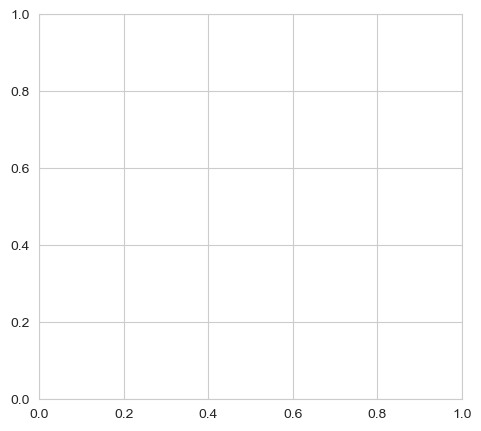

In [20]:
#Determine optimal PCA Components
print("\n" + "="*80)
print("DETERMINING OPTIMAL PCA COMPONENTS")
print("="*80)

# Fit PCA with all components
pca_full = PCA()
pca_full.fit(pca_data)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find components for different variance thresholds
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f"\n Components Required:")
print(f"   For 90% variance: {n_components_90} components")
print(f"   For 95% variance: {n_components_95} components")
print(f"   For 99% variance: {n_components_99} components")
print(f"\n   Original features: {pca_data.shape[1]}")

# Visualize variance explained
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, min(31, len(pca_full.explained_variance_ratio_))+1),
        pca_full.explained_variance_ratio_[:30])
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Scree Plot - First 30 Components')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance)
plt.axhline(y=0.90, color='g', linestyle='--', label='90%', alpha=0.7)
plt.axhline(y=0.95, color='r', linestyle='--', label='95%', alpha=0.7)
plt.axhline(y=0.99, color='orange', linestyle='--', label='99%', alpha=0.7)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Apply PCA
print("\n" + "="*80)
print("APPLYING PCA")
print("="*80)

# Use 95% variance threshold
n_components = n_components_95

print(f"\n Selected: {n_components} components (95% variance)")

# Apply PCA
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(pca_data)

# Create PCA DataFrame
pca_df = pd.DataFrame(
    pca_features,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=df.index
)

print(f"\n PCA Results:")
print(f"   Original dimensions: {pca_data.shape[1]}")
print(f"   Reduced dimensions: {n_components}")
print(f"   Reduction: {((1 - n_components/pca_data.shape[1])*100):.1f}%")
print(f"   Variance explained: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")

print(f"\n Top 10 Principal Components:")
for i in range(min(10, n_components)):
    var = pca.explained_variance_ratio_[i]
    cum_var = sum(pca.explained_variance_ratio_[:i+1])
    print(f"   PC{i+1}: {var:7.4f} ({var*100:5.2f}%) | Cumulative: {cum_var:.4f} ({cum_var*100:5.2f}%)")


APPLYING PCA

 Selected: 16 components (95% variance)

 PCA Results:
   Original dimensions: 134
   Reduced dimensions: 16
   Reduction: 88.1%
   Variance explained: 0.9516 (95.16%)

 Top 10 Principal Components:
   PC1:  0.2389 (23.89%) | Cumulative: 0.2389 (23.89%)
   PC2:  0.2119 (21.19%) | Cumulative: 0.4508 (45.08%)
   PC3:  0.1351 (13.51%) | Cumulative: 0.5859 (58.59%)
   PC4:  0.0873 ( 8.73%) | Cumulative: 0.6732 (67.32%)
   PC5:  0.0648 ( 6.48%) | Cumulative: 0.7379 (73.79%)
   PC6:  0.0567 ( 5.67%) | Cumulative: 0.7947 (79.47%)
   PC7:  0.0354 ( 3.54%) | Cumulative: 0.8300 (83.00%)
   PC8:  0.0287 ( 2.87%) | Cumulative: 0.8587 (85.87%)
   PC9:  0.0241 ( 2.41%) | Cumulative: 0.8828 (88.28%)
   PC10:  0.0166 ( 1.66%) | Cumulative: 0.8993 (89.93%)
